In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from regularization_helper import plot_it, get_simple_dataset, get_polynimial_set, plot_classifier, save_dataset
from sklearn import model_selection
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import optimizers
from fnn_helper import PlotLosses
from keras.callbacks import ModelCheckpoint 
from keras import regularizers

Using TensorFlow backend.


## Pre-procesamiento

### Cargo dataset y lo grafico

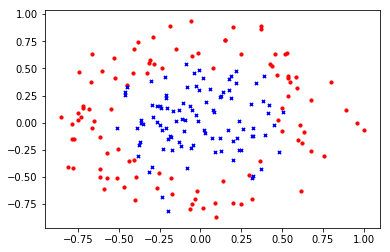

In [3]:
dataset_200 = np.load('200_samples_OK.npy')
X = dataset_200[:,:2]
y = dataset_200[:, 2]
plot_it(X,y)
plt.show()

### Divido en training y testing set

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.4, shuffle=True, random_state=500)
y_train = np.array(y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(120, 2)
(80, 2)
(120,)


## Modelo de una sola capa

### Armo arquitectura de la red

In [123]:
def get_basic_model(input_shape, output_size, lr=0.1):
    model = Sequential()
    sgd = optimizers.SGD(lr=lr)
    model.add(Dense(output_size, input_dim=input_shape,
                    activation='sigmoid', 
                    kernel_initializer='normal', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


basic_model = get_basic_model(X_train.shape[1], 1)
basic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Salida (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Entreno el modelo
- Usar distintos valores de lr 0.1, 0.05, 0.01

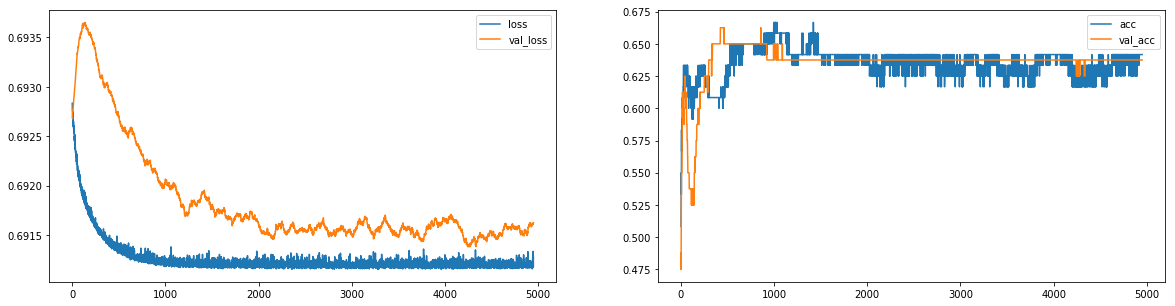

In [124]:
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
basic_model = get_basic_model(X_train.shape[1], 1, lr=0.01)
basic_model.fit(X_train, 
          y_train, batch_size = 25,
          epochs=5000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses],
         )

### Grafico resultados

In [125]:
def plot_results(model, X_train, y_train, X_test, y_test, N=200, figsize=(20,5)):
    score_train = model.evaluate(X_train, y_train, verbose=0)
    print('Train set')
    print("loss: ", score_train[0])
    print("accuracy: ", score_train[1])
    score_test = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Test set')
    print("loss: ", score_test[0])
    print("accuracy: ", score_test[1])
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=figsize)
    plot_classifier(X_train, y_train, model.predict, 1, N = N, ax=ax1)
    plot_classifier(X_test, y_test, model.predict, 1, N = N, ax=ax2)
    plt.show()
    return score_train, score_test

Train set
loss:  0.691148833434
accuracy:  0.641666662693

Test set
loss:  0.691551923752
accuracy:  0.6375


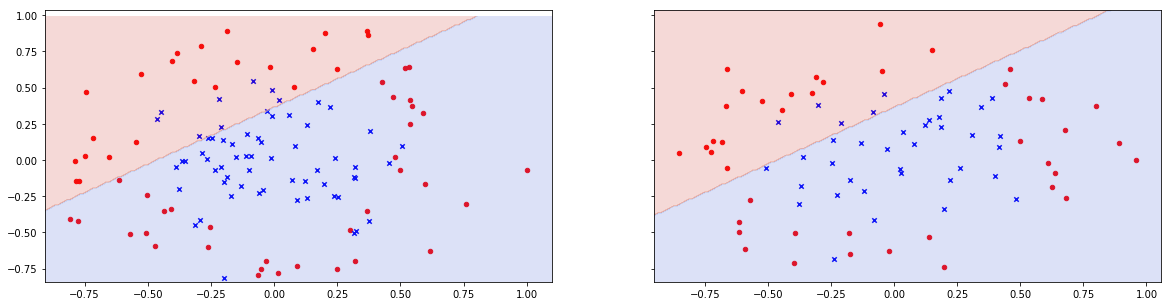

In [126]:
score_basic_model = plot_results(basic_model, X_train, y_train, X_test, y_test)

### Conclusiones
- ¿Es posible mejorar el modelo?
- UNDERFITTING
- Proponga dos posibles soluciones para mejorar el modelo: Agrandar arquitectura de la red, Regresión polinomial

## Modelo de dos capas

### Armo arquitectura de la red (10 hidden units)

In [127]:
def get_two_layer_model(input_shape, output_size, hidden_units= 10, lr=0.1, decay=0.0):
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
two_layer_model = get_two_layer_model(X_train.shape[1], 1, lr=1)
two_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                30        
_________________________________________________________________
Salida (Dense)               (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### Entreno el modelo

**Notar la diferencia entre lr entre este modelo y el anterior**

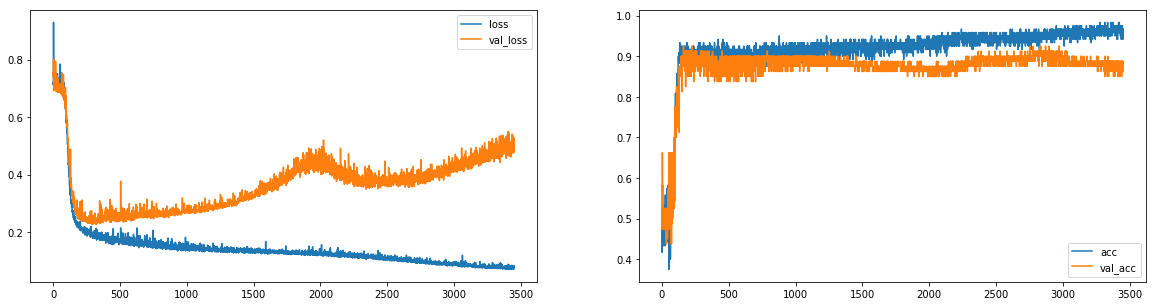

In [128]:
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.hdf5', verbose=0, save_best_only=True)
two_layer_model = get_two_layer_model(X_train.shape[1], 1, lr=2)
two_layer_model.fit(X_train, 
          y_train, batch_size = 25,
          epochs=3500, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

### Grafico resultados

Train set
loss:  0.0796171300113
accuracy:  0.95

Test set
loss:  0.575340299308
accuracy:  0.875


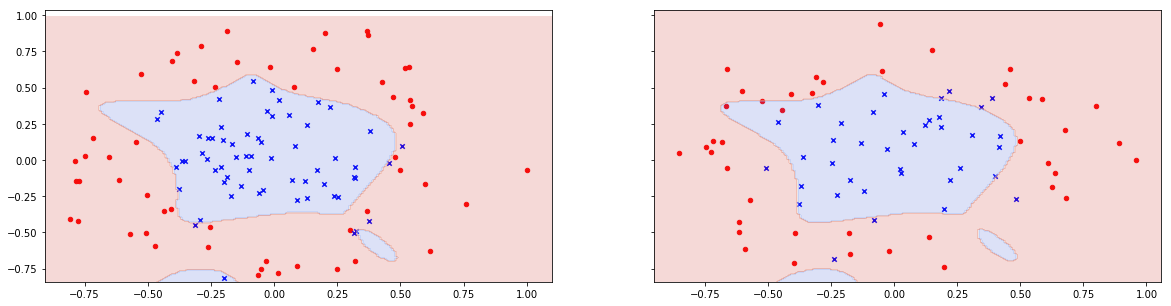

In [129]:
score_two_layer_model = plot_results(two_layer_model, X_train, y_train, X_test, y_test)

### Conclusiones:
- OVERFITTING
- ¿Posibles soluciones? Early Stop? Salir a buscar mas datos? Regularización? Dropout?

## Soluciones para el overfitting

### Early stop

Train set
loss:  0.177563457688
accuracy:  0.924999996026

Test set
loss:  0.226822866499
accuracy:  0.9125


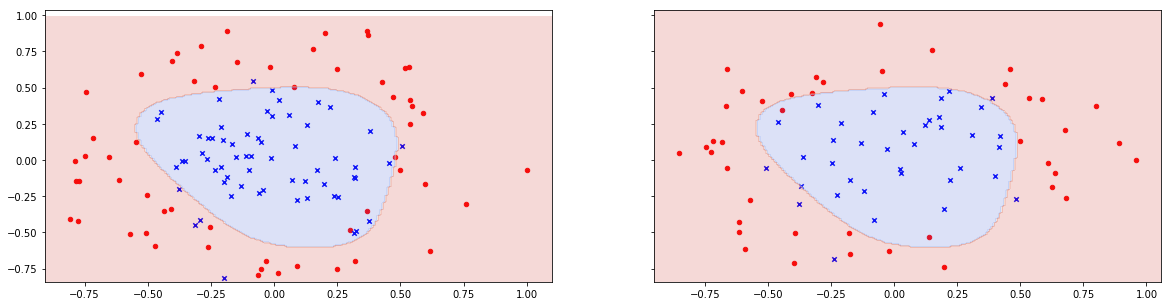

In [130]:
two_layer_model_early_stop = get_two_layer_model(X_train.shape[1], 1, lr=2)
two_layer_model_early_stop.load_weights('two_layer_model.hdf5')
score_two_layer_model_early_stop = plot_results(two_layer_model_early_stop, X_train, y_train, X_test, y_test)

In [131]:
two_layer_model_early_stop.get_weights()

[array([[ 0.61455053, -0.91025043,  0.5228371 ,  0.59970295,  8.65142345,
          0.68544406, -8.30825615,  5.70075417,  0.31885892,  0.87643778],
        [-1.11088645,  8.71713161, -0.98869574, -1.07513809, -2.52403688,
         -0.90385503, -6.8224926 , -1.2338903 , -0.23593768, -1.22815955]], dtype=float32),
 array([-0.5944013 , -3.73023391, -0.67674273, -0.74153858, -2.91375685,
        -0.62903827, -3.12717891, -2.80783153, -1.06020176, -0.25896302], dtype=float32),
 array([[ -1.54996824],
        [ 11.44610405],
        [ -1.44477093],
        [ -1.37239432],
        [  9.02686119],
        [ -1.46232927],
        [ 10.88722801],
        [  4.28874063],
        [ -0.88103718],
        [ -1.84654951]], dtype=float32),
 array([-5.60477781], dtype=float32)]

### ¿Tenemos mas data?
Cantidad de muestras mucho mayor a la cantidad de parametros

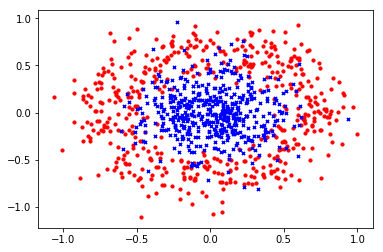

In [132]:
dataset_1000 = np.load('1000_samples.npy')
X_1000 = dataset_1000[:,:2]
y_1000 = dataset_1000[:, 2]
plot_it(X_1000,y_1000)
plt.show()

In [133]:
X_1000_train, X_1000_test, y_1000_train, y_1000_test = model_selection.train_test_split(X_1000,y_1000, test_size=0.4, shuffle=True, random_state=500)
print(X_1000_train.shape)
print(X_1000_test.shape)
print(y_1000_train.shape)

(600, 2)
(400, 2)
(600,)


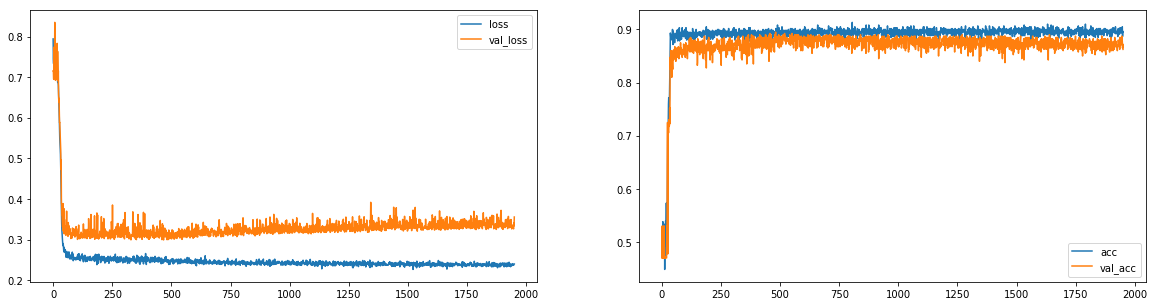

In [134]:
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_1000_test, y_val_categorical=y_1000_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.1000.hdf5', verbose=0, save_best_only=True)
two_layer_model_1000 = get_two_layer_model(X_train.shape[1], 1, lr=2)
two_layer_model_1000.fit(X_1000_train, 
          y_1000_train, batch_size = 25,
          epochs=2000, 
          verbose=0, 
          validation_data=(X_1000_test, y_1000_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.23574417611
accuracy:  0.893333334128

Test set
loss:  0.339215795994
accuracy:  0.865


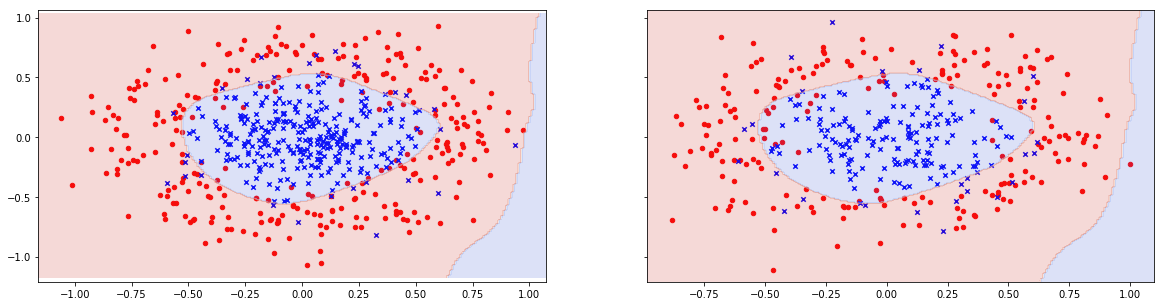

In [135]:
score_two_layer_model_1000 = plot_results(two_layer_model_1000, X_1000_train, y_1000_train, X_1000_test, y_1000_test)

#### Si lo comparamos contra el test set original:

In [56]:
score_two_layer_model_1000_test = two_layer_model_1000.evaluate(X_test, y_test, verbose=0)
print("loss: ", score_two_layer_model_1000_test[0])
print("accuracy: ", score_two_layer_model_1000_test[1])

loss:  0.268480542302
accuracy:  0.925


#### Como soluciono el ruido? Learning rate decay

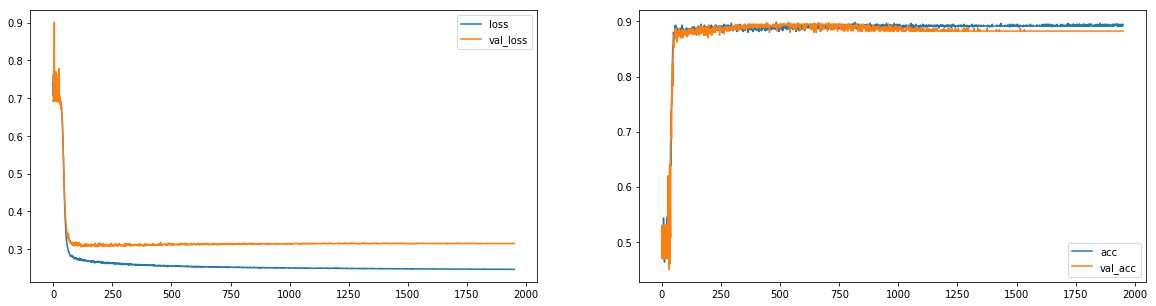

In [58]:
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_1000_test, y_val_categorical=y_1000_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.1000.hdf5', verbose=0, save_best_only=True)
two_layer_model_1000_lrd = get_two_layer_model(X_train.shape[1], 1, lr=2, decay=1e-3)
two_layer_model_1000_lrd.fit(X_1000_train, 
          y_1000_train, batch_size = 25,
          epochs=2000, 
          verbose=0, 
          validation_data=(X_1000_test, y_1000_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.245368510485
accuracy:  0.894999999205

Test set
loss:  0.314557957649
accuracy:  0.8825


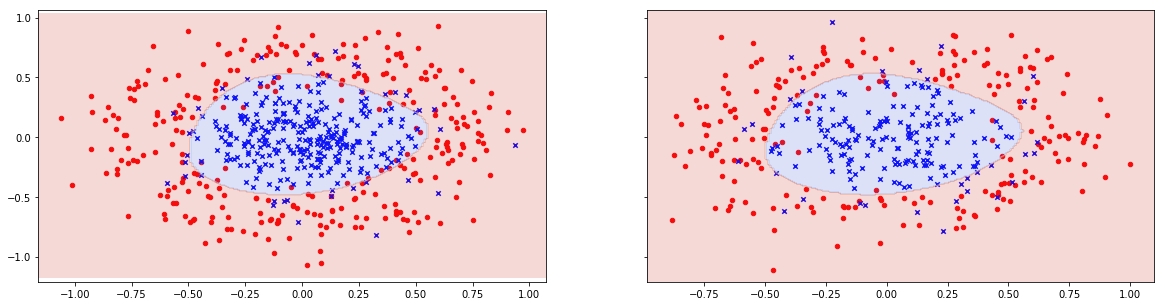

In [59]:
score_two_layer_model_1000_lrd = plot_results(two_layer_model_1000_lrd, X_1000_train, y_1000_train, X_1000_test, y_1000_test)

In [60]:
score_two_layer_model_1000__lrd_test = two_layer_model_1000_lrd.evaluate(X_test, y_test, verbose=0)
print("loss: ", score_two_layer_model_1000__lrd_test[0])
print("accuracy: ", score_two_layer_model_1000__lrd_test[1])

loss:  0.240645565093
accuracy:  0.9


### Achico red neuronal (3 hidden units) - Volvemos al dataset de 200 muestras

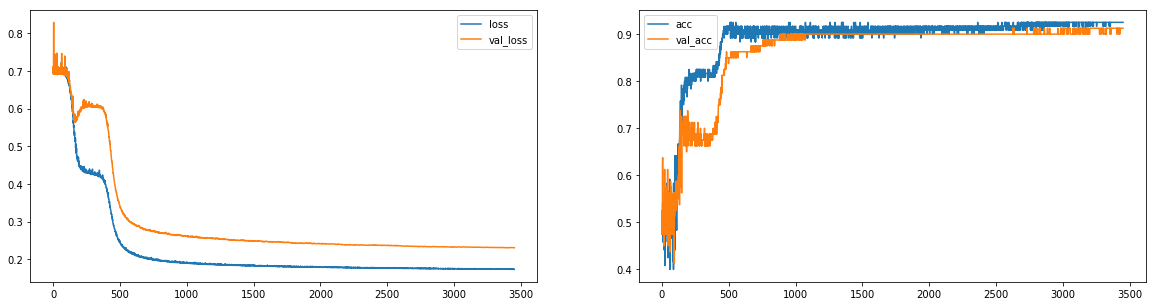

In [136]:
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.h3.hdf5', verbose=0, save_best_only=True)
two_layer_model_h3 = get_two_layer_model(X_train.shape[1], 1, hidden_units=3,lr=2, decay=1e-3)
two_layer_model_h3.fit(X_train, 
          y_train, batch_size = 25,
          epochs=3500, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.173206961652
accuracy:  0.925

Test set
loss:  0.230709274113
accuracy:  0.9125


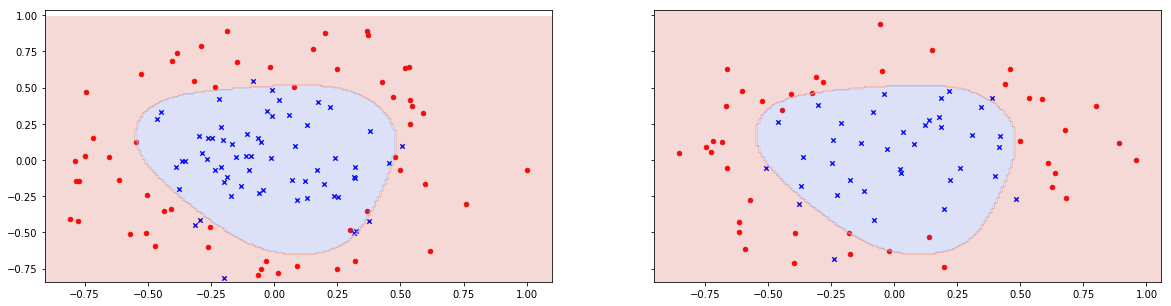

In [137]:
score_two_layer_model_1000_lrd = plot_results(two_layer_model_h3, X_train, y_train, X_test, y_test)

### Dropout (10 hidden units)

In [138]:
def get_two_layer_model_dropout(input_shape, output_size, hidden_units=10, lr=0.1, prob=0.1, decay=0.0):
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dropout(prob))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

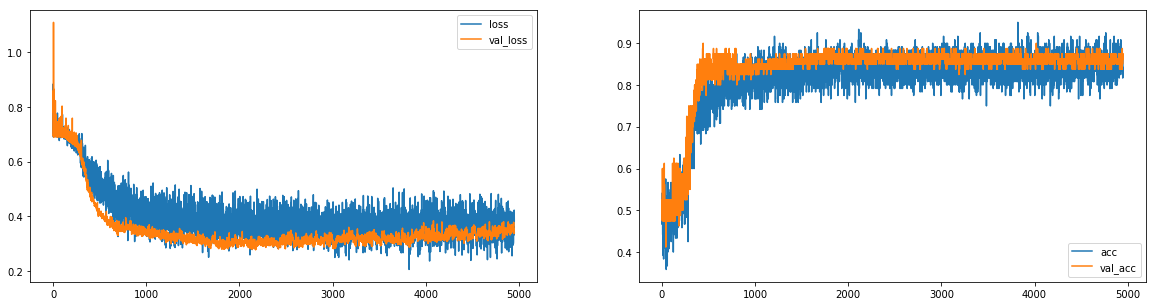

In [68]:
# Variar prob: 0.1, 0.2, 0.5
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.dropout.hdf5', verbose=0, save_best_only=True)
two_layer_model_dropout = get_two_layer_model_dropout(X_train.shape[1], 1, lr=2, decay=0.0, prob=0.5)
two_layer_model_dropout.fit(X_train, 
          y_train, batch_size = 25,
          epochs=5000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.237450741728
accuracy:  0.933333333333

Test set
loss:  0.35417189002
accuracy:  0.875


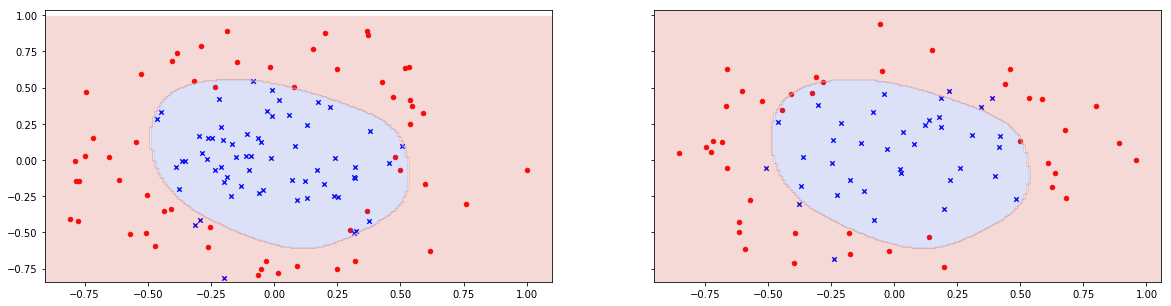

In [70]:
score_two_layer_model_1000_lrd = plot_results(two_layer_model_dropout, X_train, y_train, X_test, y_test)

### Learning rate = 1

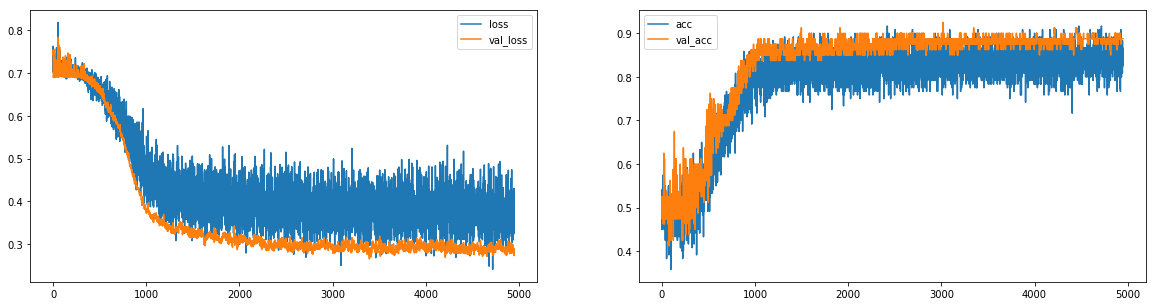

In [73]:
# Variar prob: 0.1, 0.2, 0.5
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.dropout.decay.hdf5', verbose=0, save_best_only=True)
two_layer_model_dropout_decay = get_two_layer_model_dropout(X_train.shape[1], 1, lr=1, decay=0.0, prob=0.5)
two_layer_model_dropout_decay.fit(X_train, 
          y_train, batch_size = 25,
          epochs=5000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.233160254359
accuracy:  0.908333337307

Test set
loss:  0.281398552656
accuracy:  0.875


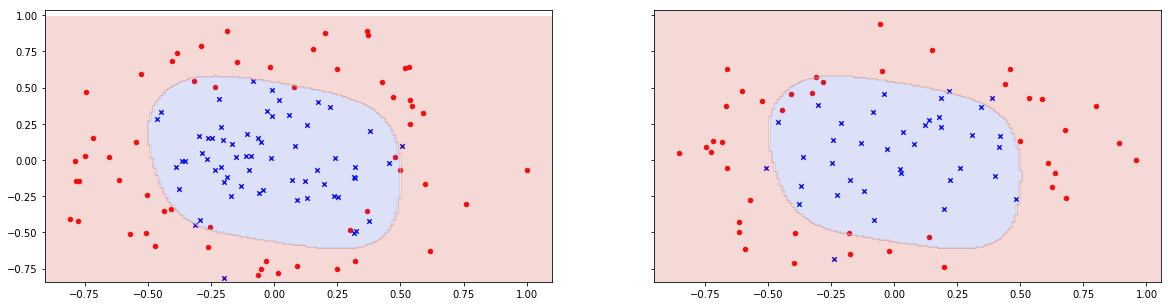

In [74]:
_ = plot_results(two_layer_model_dropout_decay, X_train, y_train, X_test, y_test)

## Regularización L2

In [106]:
def get_two_layer_model_L2(input_shape, output_size, hidden_units=10, lr=0.1, l2_lambda=0.1, decay=0.0):
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    regularizer = regularizers.l2(l2_lambda)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida',
                    kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

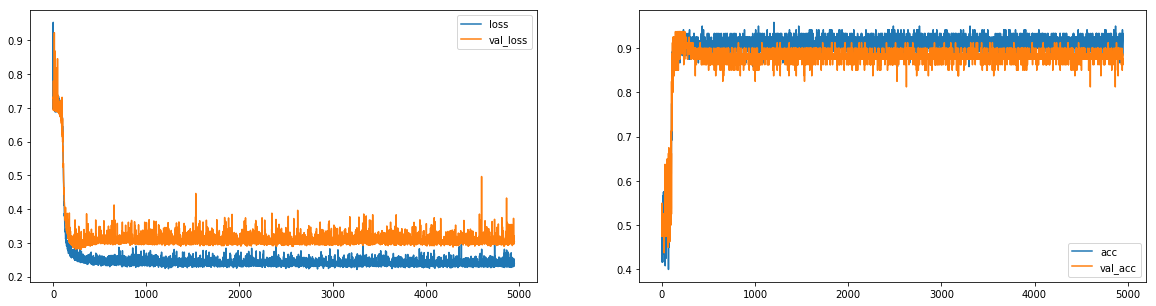

In [141]:
# Variar lambda: 0.1, 0.01, 0.005, 0.001
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.l2.hdf5', verbose=0, save_best_only=True)
two_layer_model_L2 = get_two_layer_model_L2(X_train.shape[1], 1, lr=2, decay=0.0, l2_lambda=0.0001)
two_layer_model_L2.fit(X_train, 
          y_train, batch_size = 25,
          epochs=5000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.224735561013
accuracy:  0.924999996026

Test set
loss:  0.293338251114
accuracy:  0.875


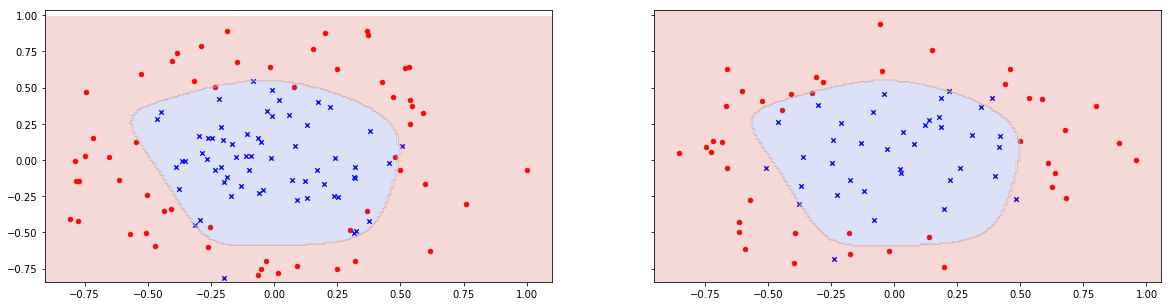

In [142]:
_ = plot_results(two_layer_model_L2, X_train, y_train, X_test, y_test)

In [143]:
def plot_hist_weights(model):
    weights = model.get_weights()
    w1 = np.concatenate((weights[0].flatten(),weights[1].flatten()))
    w2 = np.concatenate((weights[2].flatten(),weights[3].flatten()))
    wf = np.concatenate((w1,w2))
    plt.hist(wf,100)
    plt.show()

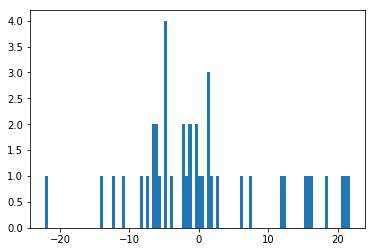

In [144]:
plot_hist_weights(two_layer_model)

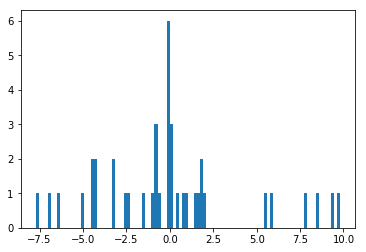

In [145]:
plot_hist_weights(two_layer_model_L2)

## Regularización L1

In [118]:
def get_two_layer_model_L1(input_shape, output_size, hidden_units=10, lr=0.1, l1_lambda=0.1, decay=0.0):
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    regularizer = regularizers.l1(l1_lambda)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', 
                    kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida',
                    kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

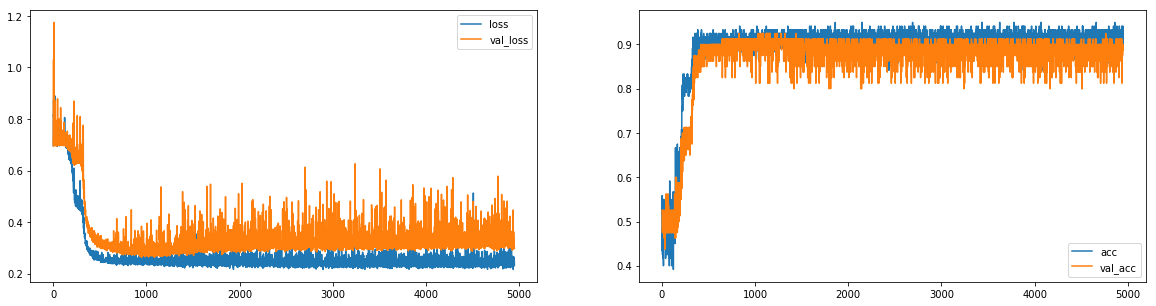

In [120]:
# Variar lambda: 0.001, 0.005
plot_losses = PlotLosses(plot_interval=50, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
checkpointer = ModelCheckpoint(filepath='two_layer_model.l1.hdf5', verbose=0, save_best_only=True)
two_layer_model_L1 = get_two_layer_model_L1(X_train.shape[1], 1, lr=2, decay=0.0, l1_lambda=0.0005)
two_layer_model_L1.fit(X_train, 
          y_train, batch_size = 25,
          epochs=5000, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

Train set
loss:  0.226158750057
accuracy:  0.95

Test set
loss:  0.306732484698
accuracy:  0.875


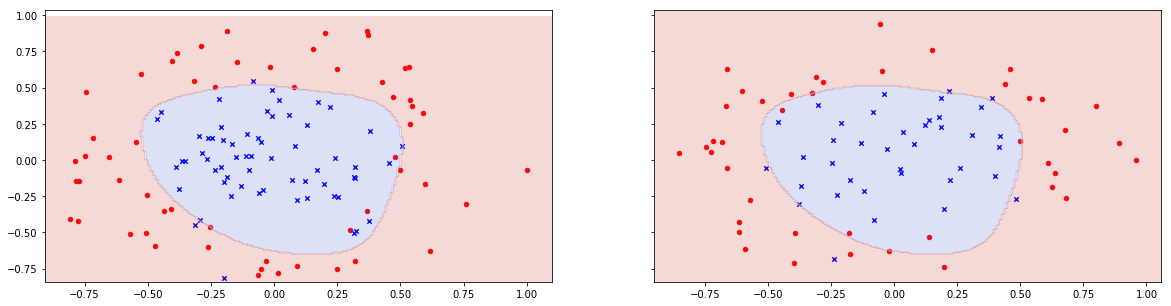

In [121]:
_ = plot_results(two_layer_model_L1, X_train, y_train, X_test, y_test)

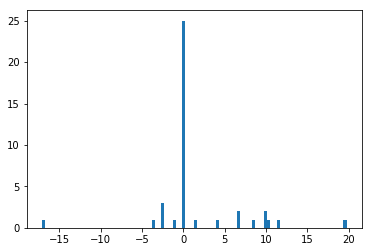

In [122]:
plot_hist_weights(two_layer_model_L1)